<a href="https://colab.research.google.com/github/kkokay07/GenomicClass_on_Cloud/blob/master/NGS_Variant_calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creator: Dr. KANAKA K. K.
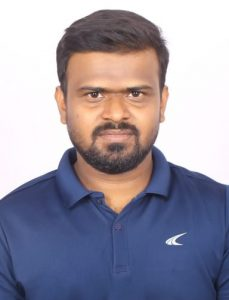

PhD, ARS  
Scientist

School of Bioinformatics

ICAR-Indian Institute of Agricultural Biotechnology, Ranchi, Jharkhand.

Spy on me at :)  
[Google Scholar](https://scholar.google.com/citations?hl=en&user=0dQ7Sf8AAAAJ&view_op=list_works);    [ResearchGate](https://www.researchgate.net/profile/Kanaka-K-K/research);    [Website](https://iiab.icar.gov.in/staff/dr-kanaka-k-k/)

**NGS Variant Calling Tutorial**

- **Aim:** Identify genetic variants (SNPs) in E. coli samples
- **Tools:** fastp, BWA, SAMtools, BCFtools
- **Input:** Two E. coli K-12 paired-end sequencing samples (SRR10527348, SRR10527349)
- **Steps:**
  1. Quality control of raw reads
  2. Alignment to reference genome
  3. BAM file processing
  4. Variant calling and filtering
- **Environment:** Google Colab (cloud-based, no local installation needed)
- **Expected output:** VCF file containing high-quality genetic variants
- **Time:** ~2 hours (depends on data download speed)

# If you find descriptions as boring, skip the text and simply run the codes!

# i. Setup Environment
"""First, we need to install the required bioinformatics tools"""

In [ ]:
# Import required libraries and setup directories
import os
from google.colab import drive
import datetime

# Mount Google Drive
drive.mount('/content/drive')

# Create directory structure
project_dir = "/content/variant_calling"
os.makedirs(project_dir, exist_ok=True)

# Create subdirectories
dirs = [
    'raw_data',
    'cleaned_data',
    'reference',
    'alignments',
    'variants',
    'reports'
]

for d in dirs:
    os.makedirs(f"{project_dir}/{d}", exist_ok=True)

print("Directory structure created successfully!")

# ii. Install tools

**fastp**
- Quality control tool for FASTQ files
- Removes low quality reads/bases
- Trims sequencing adapters
- Provides QC reports with statistics and graphs
- Filters out contaminated reads

**BWA (Burrows-Wheeler Aligner)**
- Aligns sequencing reads to reference genome
- Specially designed for short read alignment
- BWA-MEM algorithm handles paired-end reads
- Outputs alignments in SAM format
- Handles mismatches and gaps in sequences

**SAMtools**
- Manipulates SAM/BAM format files
- Converts SAM to BAM (binary format)
- Sorts and indexes BAM files
- Generates alignment statistics
- Extracts specific regions from alignments
- Views and filters aligned reads

**BCFtools**
- Variant calling from BAM files
- Creates and manipulates VCF files
- Filters variants based on quality scores
- Performs variant genotyping
- Handles multi-sample variant calling
- Allows annotation of variants

In [ ]:
# Install required tools
!apt-get update && apt-get install -y fastp bwa samtools bcftools

In [ ]:
# Install SRA toolkit
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
!tar -xzf sratoolkit.current-ubuntu64.tar.gz
!mv sratoolkit.*/bin/* /usr/local/bin/
!rm sratoolkit.current-ubuntu64.tar.gz

# iii. Understanding the Input Data: FASTQ Format

FASTQ files contain sequencing reads with quality scores. Each read has 4 lines:
1. Read identifier (starts with @)
2. Sequence
3. '+' separator
4. Quality scores (ASCII-encoded)

Example of FASTQ format:
@SRR001666.1
GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTT
+
!''*((((***+))%%%++)(%%%%).1***-+*''))**55CCF>>>>>>CCCCCCC65

Let's download a small test dataset (E. coli K-12): This tutorial demonstrates variant calling with two samples, each with paired-end reads.
Sample1 and Sample2
Each sample has forward (R1) and reverse (R2) reads.

# 1. Download samples

In [ ]:
# Download sample 1
%cd /content/variant_calling/raw_data
print("Downloading Sample 1...")
!fastq-dump --split-files SRR10527348
print("\nSample 1 files:")
!ls -lh SRR10527348*



In [ ]:
# Download sample 2
%cd /content/variant_calling/raw_data
print("\nDownloading Sample 2...")
!fastq-dump --split-files SRR10527349
print("\nSample 2 files:")
!ls -lh SRR10527349*

# 2. Reference Genome
**Reference Genome**

**Definition**: A digital nucleotide sequence database assembled to represent a species' genetic makeup, used as a standard for comparison in sequencing studies.

**Common Formats**:
- FASTA (.fa/.fasta)
  - Simple text format
  - Header line starts with '>' symbol
  - Contains sequence data in subsequent lines
  - Example:
    ```
    >Chr1
    ATGCTAGCTAGCTGATCG
    GCTAGCTAGCTGATCGAT
    ```

**Required Files for Alignment**:
- Main reference file (.fasta)
- Index files (created by tools)
  - BWA index (.amb, .ann, .bwt, .pac, .sa)
  - FASTA index (.fai)
  - Dictionary (.dict)

**Common Sources**:
- NCBI RefSeq
- Ensembl
- UCSC Genome Browser

**E. coli Reference Example**:
- Strain: K-12 MG1655
- Size: ~4.6 Mb
- Single circular chromosome
- Well-annotated for teaching purposes

In [ ]:
# Download the reference genome
%cd /content/variant_calling/reference

print("Downloading reference genome...")
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz
!gunzip GCF_000005845.2_ASM584v2_genomic.fna.gz
!mv GCF_000005845.2_ASM584v2_genomic.fna reference.fasta

**Why Index Reference Files**

1. **Speed & Efficiency**
   - Enables quick lookup of sequences
   - Avoids scanning entire file for each query
   - Reduces memory usage

2. **Random Access**
   - Allows direct access to specific regions
   - Skips reading entire genome
   - Essential for targeted analysis

3. **Tool Requirements**
   - BWA requires .amb, .ann, .bwt, .pac, .sa files
   - SAMtools needs .fai file
   - Most alignment tools won't work without indexes

4. **Common Analogy**
   - Like a book's table of contents
   - Helps find content quickly
   - Instead of reading every page

5. **Practical Impact**
   - Reduces runtime from hours to minutes
   - Enables processing of large datasets
   - Critical for high-throughput analysis

In [ ]:
# Index reference genome
print("\nIndexing reference genome...")
!bwa index reference.fasta
!samtools faidx reference.fasta

# 3. Quality Control with fastp

fastp performs quality control and filtering on FASTQ files.
- Removes low-quality bases
- Trims adapters
- Generates QC reports

Input:
- Raw FASTQ files


Output:
- Cleaned FASTQ files
- HTML report with quality metrics

**FASTQ Format** (Cleaned FASTQ files)
```
@SRR10527348.1
ATGCTAGCTAGCTGATCGATGC
+
!''*((((***+))%%%++)(%%
```
- Line 1: Header (starts with @)
- Line 2: DNA sequence
- Line 3: Separator (+)
- Line 4: Quality scores (ASCII-encoded)

**HTML Report Format**
```html
Summary Section:
- Total reads: 1,000,000
- Filtered reads: 50,000
- Q30 bases: 95%

Graphs/Charts:
- Quality score distribution
- GC content plot
- Length distribution
- Adapter content

Detailed Statistics:
- Before/After filtering metrics
- Duplication rates
- Base composition
```

Key Features of HTML Report:
- Interactive visualizations
- Color-coded metrics
- Downloadable charts
- Easy to share/view in browser
- No special software needed

*Note: fastp generates comprehensive reports that help assess sequencing quality and effectiveness of cleaning steps*

In [ ]:
# Process Sample 1
print("Processing Sample 1...")
!fastp \
    -i /content/variant_calling/raw_data/SRR10527348_1.fastq \
    -I /content/variant_calling/raw_data/SRR10527348_2.fastq \
    -o /content/variant_calling/cleaned_data/SRR10527348_1.clean.fastq.gz \
    -O /content/variant_calling/cleaned_data/SRR10527348_2.clean.fastq.gz \
    --html /content/variant_calling/reports/SRR10527348_fastp.html \
    --json /content/variant_calling/reports/SRR10527348_fastp.json \
    --qualified_quality_phred 20 \
    --length_required 50

In [ ]:
# Process Sample 2
print("\nProcessing Sample 2...")
!fastp \
    -i /content/variant_calling/raw_data/SRR10527349_1.fastq \
    -I /content/variant_calling/raw_data/SRR10527349_2.fastq \
    -o /content/variant_calling/cleaned_data/SRR10527349_1.clean.fastq.gz \
    -O /content/variant_calling/cleaned_data/SRR10527349_2.clean.fastq.gz \
    --html /content/variant_calling/reports/SRR10527349_fastp.html \
    --json /content/variant_calling/reports/SRR10527349_fastp.json \
    --qualified_quality_phred 20 \
    --length_required 50

# 5. Alignment with BWA-MEM

BWA-MEM aligns cleaned reads to the reference genome.

Input: Cleaned FASTQ files + indexed reference

Output: SAM file (Sequence Alignment/Map format)

Example SAM format:
@SQ     SN:ref  LN:45
r001    163     ref     7       30      8M2I4M1D3M      =       37      39      TTAGATAAAGGATACTG     *


In [ ]:
# Align Sample 1
print("Aligning Sample 1...")
!bwa mem -t 2 \
    /content/variant_calling/reference/reference.fasta \
    /content/variant_calling/cleaned_data/SRR10527348_1.clean.fastq.gz \
    /content/variant_calling/cleaned_data/SRR10527348_2.clean.fastq.gz \
    > /content/variant_calling/alignments/SRR10527348.sam

In [ ]:
# Align Sample 2
print("\nAligning Sample 2...")
!bwa mem -t 2 \
    /content/variant_calling/reference/reference.fasta \
    /content/variant_calling/cleaned_data/SRR10527349_1.clean.fastq.gz \
    /content/variant_calling/cleaned_data/SRR10527349_2.clean.fastq.gz \
    > /content/variant_calling/alignments/SRR10527349.sam

# 6. SAM to BAM Conversion

Convert SAM to BAM (binary format), sort, and index for efficient processing:

**SAM to BAM Conversion Importance**

1. **Storage Space**
   - BAM is binary (compressed) format
   - Takes 3-4x less space than SAM
   - Crucial for large datasets

2. **Processing Speed**
   - BAM files process faster
   - Binary format = quicker computer reading
   - Essential for high-throughput analysis

3. **Required for Tools**
   - Most tools require BAM format
   - Sorting and indexing needs BAM
   - Standard in variant calling pipelines

4. **Data Security**
   - Less chance of corruption
   - Maintains data integrity
   - Checksums can verify content

5. **Sorting & Indexing**
   - BAM files can be sorted by position
   - Enables creation of index files
   - Allows quick access to specific regions

6. **Compatibility**
   - Industry standard format
   - Works with all major tools
   - Required for downstream analysis

7. **Memory Efficiency**
   - Better memory handling
   - Faster data streaming
   - Efficient parallel processing

In [ ]:
# Process Sample 1
!samtools view -bS /content/variant_calling/alignments/SRR10527348.sam > /content/variant_calling/alignments/SRR10527348.bam
!samtools sort /content/variant_calling/alignments/SRR10527348.bam -o /content/variant_calling/alignments/SRR10527348.sorted.bam
!samtools index /content/variant_calling/alignments/SRR10527348.sorted.bam
!rm /content/variant_calling/alignments/SRR10527348.sam /content/variant_calling/alignments/SRR10527348.bam

In [ ]:
# Process Sample 2
!samtools view -bS /content/variant_calling/alignments/SRR10527349.sam > /content/variant_calling/alignments/SRR10527349.bam
!samtools sort /content/variant_calling/alignments/SRR10527349.bam -o /content/variant_calling/alignments/SRR10527349.sorted.bam
!samtools index /content/variant_calling/alignments/SRR10527349.sorted.bam
!rm /content/variant_calling/alignments/SRR10527349.sam /content/variant_calling/alignments/SRR10527349.bam

# 7. Variant Calling with BCFtools

Call variants from the aligned reads.

Input: Sorted BAM files + reference

Output: VCF file (Variant Call Format)

Example VCF format:
CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO
20      14370   rs6054257       G       A       29      PASS    NS=3;DP=14;AF=0.5

**Variant Calling Overview**

1. **Definition**
   - Process of identifying DNA sequence variations
   - Compares sample reads to reference genome
   - Detects SNPs, insertions, deletions, etc.

2. **Key Requirements**
   - Quality-filtered reads
   - Properly aligned BAM files
   - Indexed reference genome
   - Sufficient read depth/coverage

3. **Basic Steps**
   - Pile up reads at each position
   - Calculate allele frequencies
   - Apply quality filters
   - Determine genotypes
   - Estimate confidence scores

4. **Common Variants Types**
   - SNPs (Single Nucleotide Polymorphisms)
   - Indels (Insertions/Deletions)
   - Structural Variants
   - Copy Number Variations

5. **Output Format (VCF)**
   - Chromosome
   - Position
   - Reference allele
   - Alternative allele
   - Quality scores
   - Additional annotations

6. **Important Metrics**
   - Read depth (coverage)
   - Mapping quality
   - Base quality
   - Genotype quality
   - Allele frequency

7. **Common Filters**
   - Minimum read depth
   - Minimum quality score
   - Strand bias
   - Mapping quality
   - Allele balance

In [ ]:
# Prepare for variant calling
%cd /content/variant_calling/variants

# Create list of BAM files
!ls /content/variant_calling/alignments/*.sorted.bam > bam_list.txt

In [ ]:
# Run variant calling
!bcftools mpileup \
    -f /content/variant_calling/reference/reference.fasta \
    -b bam_list.txt \
    -d 1000 \
    -q 20 \
    -Q 20 \
    --annotate FORMAT/AD,FORMAT/DP \
    -Ou | \
    bcftools call -mv --ploidy 2 -P 0.01 -Oz \
    -o variants.vcf.gz

In [ ]:
# Index VCF
!bcftools index variants.vcf.gz

Here are the key points about VCF filtering importance:

- Removes low-quality variant calls to reduce false positives
- Ensures adequate sequencing coverage by filtering based on read depth
- Increases reliability of downstream genetic analyses
- Makes data more manageable by reducing file size
- Maintains high-confidence variants for research validity

In [ ]:
# Filter variants
!bcftools filter \
    -i 'QUAL>=20 && FORMAT/DP>=10' \
    -O z \
    -o variants.filtered.vcf.gz \
    variants.vcf.gz

!bcftools index variants.filtered.vcf.gz

# 8. Examining output files to understand output file format

1. fastp_report.html: Quality control metrics and graphs
2. cleaned_R1/R2.fastq.gz: Filtered reads
3. sorted.bam: Aligned reads in binary format
4. variants.vcf: Final variants in VCF format

Key VCF Fields:
- CHROM: Chromosome
- POS: Position in reference
- REF: Reference base(s)
- ALT: Alternative base(s)
- QUAL: Quality score
- FILTER: Whether variant passed filters


In [ ]:
# Check alignment statistics
print("Checking alignment statistics...")
!samtools flagstat /content/variant_calling/alignments/SRR10527348.sorted.bam
!samtools flagstat /content/variant_calling/alignments/SRR10527349.sorted.bam

In [ ]:
# Check variant counts
print("\nChecking variant counts:")
!echo "Raw variants:"
!bcftools view /content/variant_calling/variants/variants.vcf.gz | grep -v "^#" | wc -l
!echo "Filtered variants:"
!bcftools view /content/variant_calling/variants/variants.filtered.vcf.gz | grep -v "^#" | wc -l

In [ ]:
# View first few variants
print("\nFirst few variants:")
!bcftools view /content/variant_calling/variants/variants.filtered.vcf.gz | head -n 10

# Take home message
Here are the key takeaways for the fastp to VCF generation pipeline:

Input Files:
- Raw FASTQ files (paired-end reads)
- Reference genome FASTA file

Key Steps:
- Quality control with fastp (trimming adapters, low quality bases)
- Read alignment to reference using BWA-MEM
- Convert SAM to BAM format and sort
- Variant calling with BCFtools to generate VCF
- VCF filtering based on quality metrics

Important Output Files:
- Cleaned FASTQ files from fastp
- QC reports showing read quality metrics
- Sorted BAM files containing aligned reads
- VCF file with filtered variants
- Alignment statistics reports

Best Practices:
- Always check QC reports before proceeding
- Index reference genome and BAM files
- Sort BAM files before variant calling
- Apply appropriate filters to raw VCF file
- Keep track of intermediate files and reports